# Intro to Graphs


- General language for describing and analyzing entities with relations/interactions

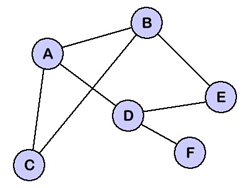

- Complex domains have rich relation structure, which can be represented as a relational graph.
- By explicitly modeling relationships we could achieve better performance.

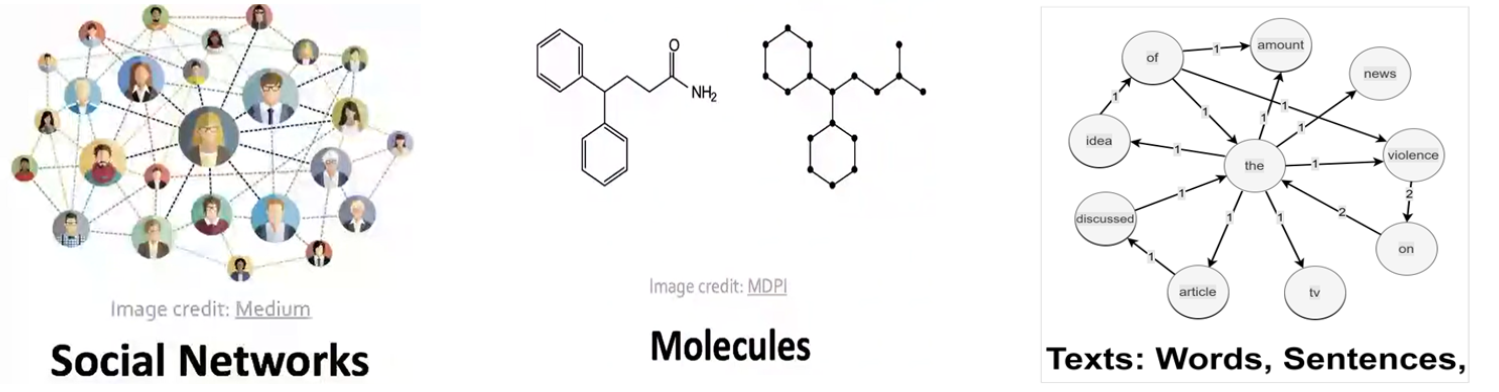

# Configs

## Install & Load Dependencies

In [ ]:
!pip install text2graphapi
!pip install datasets
!pip install contractions

!pip install torch
!pip install torch-scatter -f https://data.pyg.org/whl/torch-2.1.2+cu118.html
!pip install torch-sparse -f https://data.pyg.org/whl/torch-2.1.2+cu118.html
!pip install torch-cluster -f https://data.pyg.org/whl/torch-2.1.2+cu118.html
!pip install git+https://github.com/pyg-team/pytorch_geometric.git

Looking in links: https://data.pyg.org/whl/torch-2.1.2+cu118.html
Looking in links: https://data.pyg.org/whl/torch-2.1.2+cu118.html
Looking in links: https://data.pyg.org/whl/torch-2.1.2+cu118.html
  Cloning https://github.com/pyg-team/pytorch_geometric.git to /tmp/pip-req-build-18oi44u0
  Running command git clone --filter=blob:none --quiet https://github.com/pyg-team/pytorch_geometric.git /tmp/pip-req-build-18oi44u0
  Resolved https://github.com/pyg-team/pytorch_geometric.git to commit ab6037b93077ca936a92b1a5ae876403e30cde0c
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [ ]:
import time
import numpy as np
import pandas as pd
import glob
import joblib
from tqdm import tqdm
import os
import scipy as sp
from scipy.sparse import coo_array

from nltk.tokenize import sent_tokenize, word_tokenize
import warnings
from sklearn.utils import shuffle

warnings.filterwarnings(action='ignore')


In [ ]:
import joblib
from tqdm import tqdm
import os
import networkx as nx
from sklearn.datasets import fetch_20newsgroups
from torch_geometric.data import DataLoader, Dataset, Data
from torch_geometric.datasets import TUDataset
from torch_geometric.datasets import Planetoid
from torch_geometric.transforms import NormalizeFeatures
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
import torch.nn.functional as F
import torch.nn as nn
from torch_geometric.nn import (
    GCNConv, GATConv, TransformerConv,
    global_mean_pool, global_max_pool, global_add_pool,
    GlobalAttention, Set2Set
)

import torch
from torch.nn import Linear
import torch.nn.functional as F
from sklearn.manifold import TSNE

import nltk
nltk.download('punkt_tab')


[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

## Utility Functions

In [ ]:
def read_json(file_path):
  df = pd.read_json(file_path, lines=True)
  df = df.sort_values('id', ascending=True)
  return df

def save_data(data, file_name, path='/', format_file='.pkl', compress=False):
    path_file = os.path.join(path, file_name + format_file)
    joblib.dump(data, path_file, compress=compress)

def delete_dir_files(dir_path):
  files = glob.glob(dir_path + '/*')
  for f in files:
      os.remove(f)

def create_dir(dir_path):
  if not os.path.exists(dir_path):
    os.makedirs(dir_path)

def cut_dataset(corpus_text_docs, cut_percentage_dataset):
  cut_dataset = len(corpus_text_docs) * (int(cut_percentage_dataset) / 100)
  return corpus_text_docs[:int(cut_dataset)]

def w2v(graph_data):
  words_nodes = []
  model = None
  for g in graph_data:
    words_nodes.append(list(g['graph'].nodes))
  # Create CBOW model
  model = gensim.models.Word2Vec(words_nodes, min_count=1, vector_size=100, window=5)
  return model

# TESTING DOC CORPUS
def read_custom_dataset():
  return [
      {'id': 1, 'doc': "Artificial Intelligence is the ability of a digital computer or computer-controlled robot to perform tasks commonly associated with intelligent beings", "context": {"target": 1}},
      {'id': 2, 'doc': "Natural language processing refers to the branch of computer science that focus on the ability of computers to understand text and spoken words in much the same way human beings can", "context": {"target": 1}},
      {'id': 3, 'doc': "Authorship verification is the task of deciding whether two texts have been written by the same author based on comparing the texts' writing styles", "context": {"target": 0}},
      {'id': 4, 'doc': "Feature extraction refers to the process of transforming raw data into numerical features ", "context": {"target": 1}},
      {'id': 5, 'doc': "A graph neural network is a class of artificial neural networks for processing data that can be represented as graphs.", "context": {"target": 0}},
  ]

# 20 News Group
def read_20_newsgroups_dataset(subset='train'):
    newsgroups_dataset = fetch_20newsgroups(subset=subset) #subset='train', fetch from sci-kit learn
    id = 1
    corpus_text_docs = []
    for index in range(len(newsgroups_dataset.data)):
        doc = {"id": id, "doc": newsgroups_dataset.data[index], "context": {"target": newsgroups_dataset.target[index]}}
        corpus_text_docs.append(doc)
        id += 1
    return corpus_text_docs

# Cora dataset
def read_cora_dataset():
  dataset = Planetoid(root='data/Planetoid', name='Cora', transform=NormalizeFeatures())
  return dataset

# TU dataset
def read_tu_dataset(name='MUTAG'):
  dataset = TUDataset(root='data/TUDataset', name=name)
  dataset = dataset.shuffle()
  return dataset


def plot_digraph(G, node_size=900, layout='spring', edge_width_scale=1.0, title="Text Graph Visualization"):
    # Layout selection
    if layout == 'spring':
        pos = nx.spring_layout(G, seed=42)
    elif layout == 'circular':
        pos = nx.circular_layout(G)
    else:
        pos = nx.kamada_kawai_layout(G)

    # Plotting
    plt.figure(figsize=(8, 6))

    # Draw nodes (with labels if they exist)
    node_color = "skyblue"
    nx.draw_networkx_nodes(G, pos, node_size=node_size, node_color=node_color)

    # Use node labels if present, else use node IDs
    labels = nx.get_node_attributes(G, 'label') if hasattr(G, 'label') else {n: n for n in G.nodes()}
    nx.draw_networkx_labels(G, pos, labels=labels, font_size=12)

    # Draw edges (with weights if they exist)
    edge_widths = [G[u][v].get('weight', 1.0) * edge_width_scale for u, v in G.edges()]
    nx.draw_networkx_edges(
        G, pos,
        width=edge_widths,
        edge_color="gray",
        arrows=True,
        arrowstyle="->",
        arrowsize=20
    )

    # Add edge weight labels if weights exist
    if any('weight' in G[u][v] for u, v in G.edges()):
        edge_labels = nx.get_edge_attributes(G, 'weight')
        nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=10)

    plt.title(title, fontsize=14)
    plt.axis("off")
    plt.tight_layout()
    plt.show()


def visualize(h, color):
    z = TSNE(n_components=2).fit_transform(h.detach().cpu().numpy())

    plt.figure(figsize=(10,10))
    plt.xticks([])
    plt.yticks([])

    plt.scatter(z[:, 0], z[:, 1], s=70, c=color, cmap="Set2")
    plt.show()

def read_autext23_dataset():
  autext23_train_url = f"https://drive.google.com/uc?id=1hswEB5H2YGuATbb-Bh9XSXZ8xYdgin5Q&export=download"
  autext23_val_url = f"https://drive.google.com/uc?id=15ev_z4kwN1dJa4d27a7COWG_6DBmp65p&export=download"
  autext23_test_url = f"https://drive.google.com/uc?id=1dp5yoqgaGDB1F2jK353pTPDC6R7ReElh&export=download"
  autext23_train_df = pd.read_csv(autext23_train_url)
  autext23_val_df = pd.read_csv(autext23_val_url)
  autext23_test_df = pd.read_csv(autext23_test_url)
  return autext23_train_df, autext23_val_df, autext23_test_df

def process_autext23_dataset(df):
  text_data_lst = []
  df_dict = df.to_dict('records')
  for instance in df_dict:
    doc = {
        "id": instance['id'],
        "doc": instance['text'][:],
        "context": {"label": instance['label'], "text": instance['text'], "model": instance['model'] }
    }
    text_data_lst.append(doc)
  return text_data_lst

def add_context(instances, graphs):
  for i in instances:
    for g in graphs:
        if g['doc_id'] == i['id']:
            g['context'] = i['context']
            break
  return graphs


# Graph Neural Networks

## PyTorch Geometric

* PyTorch Geometric (PyG) is a powerful library built on PyTorch
* Designed specifically for deep learning on graphs and irregular structures
* It provides efficient and scalable tools for implementing Graph Neural Networks


--------------------------------------

PyG introduces the torch_geometric.data.Data class to represent graphs with:

- node features (x) – Features for each node (e.g., word embeddings).
- edge connections (edge_index) – Graph connectivity in COO (Coordinate) format.
- edge features (optional) – Attributes for each edge.
- node labels (y) – Target labels for node/edge/graph classification.


In [ ]:
from torch_geometric.data import Data

# nodes: 1,2,3
x = torch.tensor([[1.0], [2.0], [3.0]])  # Node features
y = torch.tensor([0, 1, 0])  # Node labels
edge_index = torch.tensor([[0, 1, 1, 2], [1, 0, 2, 1]], dtype=torch.long)  # COO format [2 x num_edges]

data = Data(x=x, edge_index=edge_index, y=y)
print(data)  # Output: Data(x=[3, 1], edge_index=[2, 4], y=[3])

Data(x=[3, 1], edge_index=[2, 4], y=[3])


--------------------------------------
PyG provides state-of-the-art GNN layers:

- GCNConv (Graph Convolutional Network)
- GATConv (Graph Attention Network)
- SAGEConv (GraphSAGE)
- TransformerConv (Graph Transformer)


--------------------------------------

Built-in Benchmark Datasets
- PyG includes popular graph datasets:
- Cora, CiteSeer, PubMed (Citation networks)
- PPI (Protein-Protein Interaction)
- MUTAG (Molecule properties)

## Cora dataset

- The Cora dataset is a benchmark citation network dataset widely used for graph deep learning and node classification tasks.
- 2,708 academic machine learning papers (nodes)
- 5,429 citation directed edges (paper A → paper B)
- 7 categories (classes) of papers
- The dataset is small enough for quick experiments but complex enough to test model capabilities

In [ ]:
dataset = Planetoid(root='data/Planetoid', name='Cora', transform=NormalizeFeatures())
data = dataset[0]  # Get the first (and only) graph

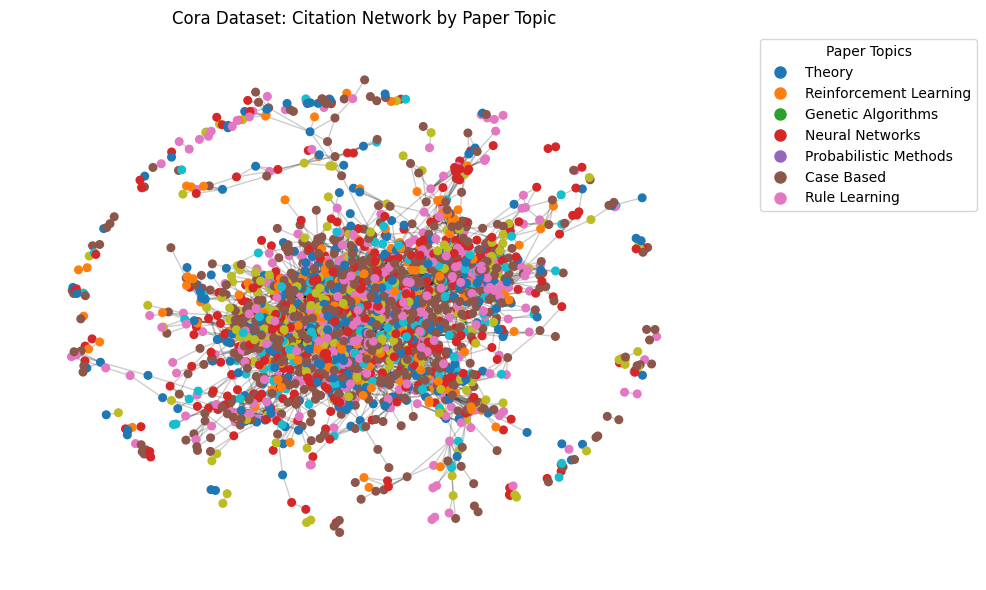

In [ ]:
G = nx.Graph()
G.add_edges_from(data.edge_index.t().tolist())

# Map class indices to meaningful labels (example for Cora)
class_labels = {0: "Theory", 1: "Reinforcement Learning", 2: "Genetic Algorithms", 3: "Neural Networks", 4: "Probabilistic Methods", 5: "Case Based", 6: "Rule Learning"}

# Plot the graph with colored nodes
plt.figure(figsize=(10, 6))
pos = nx.spring_layout(G, seed=42)  # Layout for consistency
node_colors = data.y.numpy()

# Draw nodes and edges
nx.draw_networkx_edges(G, pos, alpha=0.2)
scatter = nx.draw_networkx_nodes(G, pos, node_size=30, node_color=node_colors,cmap='tab10',  vmin=0,vmax=6)

# Create a legend box
legend_elements = [
    Line2D([0], [0], marker='o', color='w', label=class_labels[i],
           markerfacecolor=plt.cm.tab10(i), markersize=10)
    for i in range(7)
]

plt.legend(handles=legend_elements, title="Paper Topics",bbox_to_anchor=(1.05, 1), loc='upper left')

plt.title("Cora Dataset: Citation Network by Paper Topic")
plt.axis('off')  # Hide axes
plt.tight_layout()  # Adjust layout to fit legend
plt.show()

In [ ]:
# Get some basic info about the dataset
print(f'Number of graphs: {len(dataset)}')
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')
print(f'Number of training nodes: {data.train_mask.sum()}')
print(f'Training node label rate: {int(data.train_mask.sum()) / data.num_nodes:.2f}')
print(f'Is undirected: {data.is_undirected()}')
print(50*'=')

# Gather some statistics about the graph.
print(data)

Number of graphs: 1
Number of nodes: 2708
Number of edges: 10556
Number of features: 1433
Number of classes: 7
Number of training nodes: 140
Training node label rate: 0.05
Is undirected: True
Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])


In [ ]:
print("\n------------------- features (x): ")
print(data.x.shape) # [No. Nodes x Features]

# Print some of the normalized word counts of the first datapoint
print("\n------------------- edge_index: ")
print(data.x[0][:50])

print("\n------------------- edge_index: ")
print(data.edge_index.t()) # [2 x No. Edges]

print("\n------------------- labels: ")
print(data.y)

print("\n------------------- bool masks: ")
print("train mask: ", data.train_mask)
print(f'Number of train nodes: {data.train_mask.sum()}')
print(f'Number of val   nodes: {data.val_mask.sum()}')
print(f'Number of test  nodes: {data.test_mask.sum()}')


------------------- features (x): 
torch.Size([2708, 1433])

------------------- edge_index: 
tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.1111, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000])

------------------- edge_index: 
tensor([[ 633,    0],
        [1862,    0],
        [2582,    0],
        ...,
        [ 598, 2707],
        [1473, 2707],
        [2706, 2707]])

------------------- labels: 
tensor([3, 4, 4,  ..., 3, 3, 3])

------------------- bool masks: 
train mask:  tensor([ True,  True,  True,  ..., False, False, False])
Number of train nodes: 140
Number of val   nodes: 500
Number of test  nodes: 1000


## Types of Graph Neural Networks Tasks

Applications/Task:
- Graph Classification (e.g., molecule property prediction)
- Node Classification (e.g., predicting paper topics in Cora)
- Link Prediction (e.g., recommendation systems)


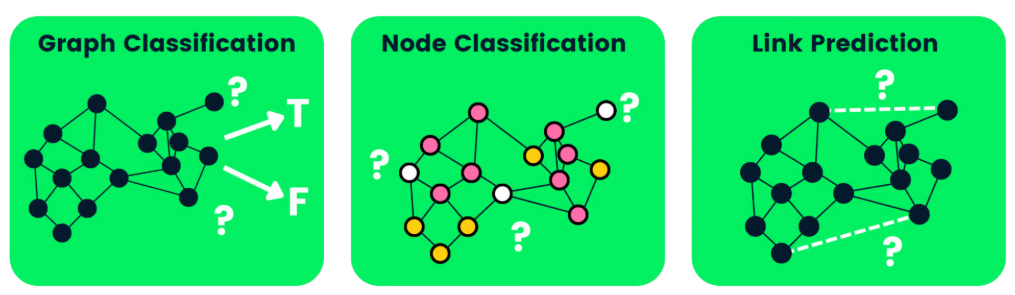

https://www.datacamp.com/tutorial/comprehensive-introduction-graph-neural-networks-gnns-tutorial

## Multi Layer Perceptron

In [ ]:

class MLP(torch.nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()
        torch.manual_seed(12345)
        self.lin1 = Linear(dataset.num_features, hidden_channels)
        self.lin2 = Linear(hidden_channels, dataset.num_classes)

    def forward(self, x):
        x = self.lin1(x)
        x = x.relu()
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin2(x)
        return x

model = MLP(hidden_channels=16)
print(model)
print()
print(data)

MLP(
  (lin1): Linear(in_features=1433, out_features=16, bias=True)
  (lin2): Linear(in_features=16, out_features=7, bias=True)
)

Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])


In [ ]:
from IPython.display import Javascript  # Restrict height of output cell.
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 300})'''))

model = MLP(hidden_channels=16)
criterion = torch.nn.CrossEntropyLoss()  # Define loss criterion.
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)  # Define optimizer.

def train():
      model.train()
      optimizer.zero_grad()  # Clear gradients.
      out = model(data.x)  # Perform a single forward pass.
      loss = criterion(out[data.train_mask], data.y[data.train_mask])  # Compute the loss solely based on the training nodes.
      loss.backward()  # Derive gradients.
      optimizer.step()  # Update parameters based on gradients.
      return loss

def test():
      model.eval()
      out = model(data.x)
      pred = out.argmax(dim=1)  # Use the class with highest probability.
      test_correct = pred[data.test_mask] == data.y[data.test_mask]  # Check against ground-truth labels.
      test_acc = int(test_correct.sum()) / int(data.test_mask.sum())  # Derive ratio of correct predictions.
      return test_acc

for epoch in range(1, 201):
    loss = train()
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}')

<IPython.core.display.Javascript object>

Epoch: 001, Loss: 1.9615
Epoch: 002, Loss: 1.9557
Epoch: 003, Loss: 1.9505
Epoch: 004, Loss: 1.9423
Epoch: 005, Loss: 1.9327
Epoch: 006, Loss: 1.9279
Epoch: 007, Loss: 1.9144
Epoch: 008, Loss: 1.9087
Epoch: 009, Loss: 1.9023
Epoch: 010, Loss: 1.8893
Epoch: 011, Loss: 1.8776
Epoch: 012, Loss: 1.8594
Epoch: 013, Loss: 1.8457
Epoch: 014, Loss: 1.8365
Epoch: 015, Loss: 1.8280
Epoch: 016, Loss: 1.7965
Epoch: 017, Loss: 1.7984
Epoch: 018, Loss: 1.7832
Epoch: 019, Loss: 1.7495
Epoch: 020, Loss: 1.7441
Epoch: 021, Loss: 1.7188
Epoch: 022, Loss: 1.7124
Epoch: 023, Loss: 1.6785
Epoch: 024, Loss: 1.6660
Epoch: 025, Loss: 1.6119
Epoch: 026, Loss: 1.6236
Epoch: 027, Loss: 1.5827
Epoch: 028, Loss: 1.5784
Epoch: 029, Loss: 1.5524
Epoch: 030, Loss: 1.5020
Epoch: 031, Loss: 1.5065
Epoch: 032, Loss: 1.4742
Epoch: 033, Loss: 1.4581
Epoch: 034, Loss: 1.4246
Epoch: 035, Loss: 1.4131
Epoch: 036, Loss: 1.4112
Epoch: 037, Loss: 1.3923
Epoch: 038, Loss: 1.3055
Epoch: 039, Loss: 1.2982
Epoch: 040, Loss: 1.2543


In [ ]:
test_acc = test()
print(f'Test Accuracy: {test_acc:.4f}')

Test Accuracy: 0.5900


## Graph Convolutional Networks

- A Graph Convolutional Network (GCN) is a type of Graph Neural Network (GNN) designed to process graph-structured data by aggregating information from neighboring nodes.
- It generalizes convolutional operations from grid-like data (e.g., images) to irregular graphs.

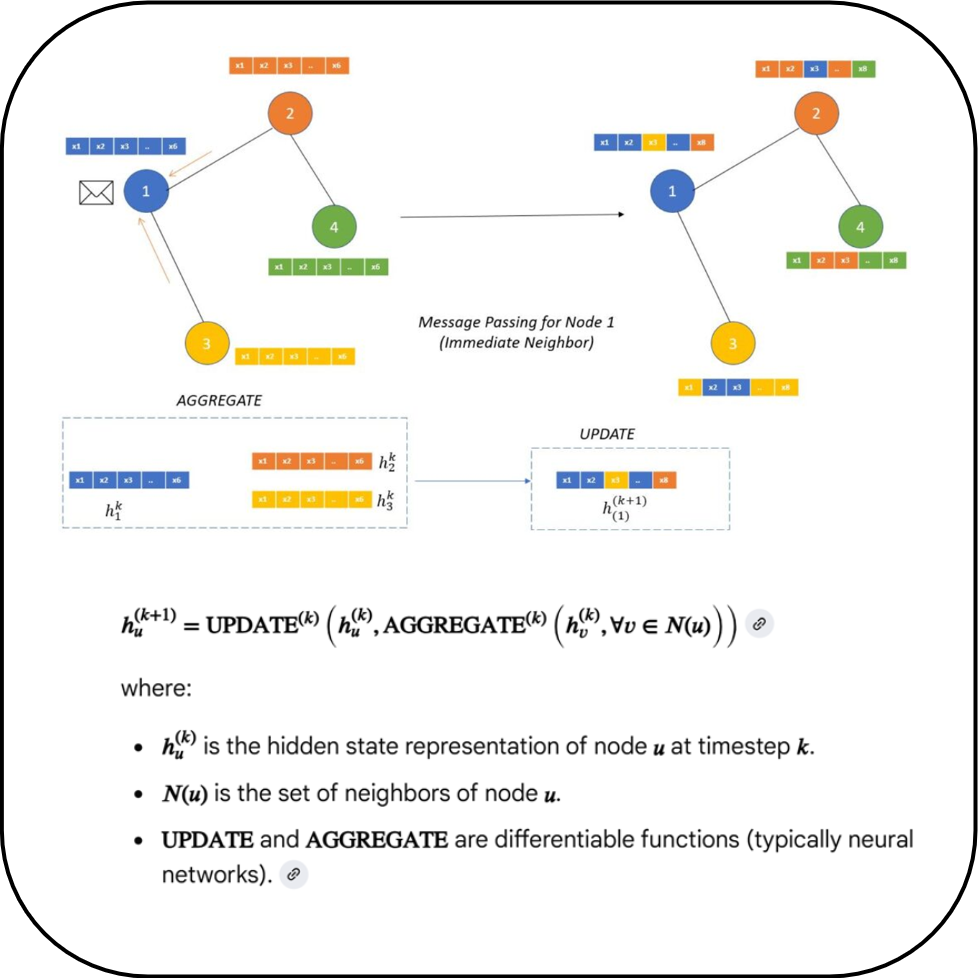

In [ ]:
from torch_geometric.nn import GCNConv

class GCN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()
        torch.manual_seed(1234567)
        self.conv1 = GCNConv(dataset.num_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, dataset.num_classes)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index)
        return x

model = GCN(hidden_channels=16)
print(model)
print()
print(data)

GCN(
  (conv1): GCNConv(1433, 16)
  (conv2): GCNConv(16, 7)
)

Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])


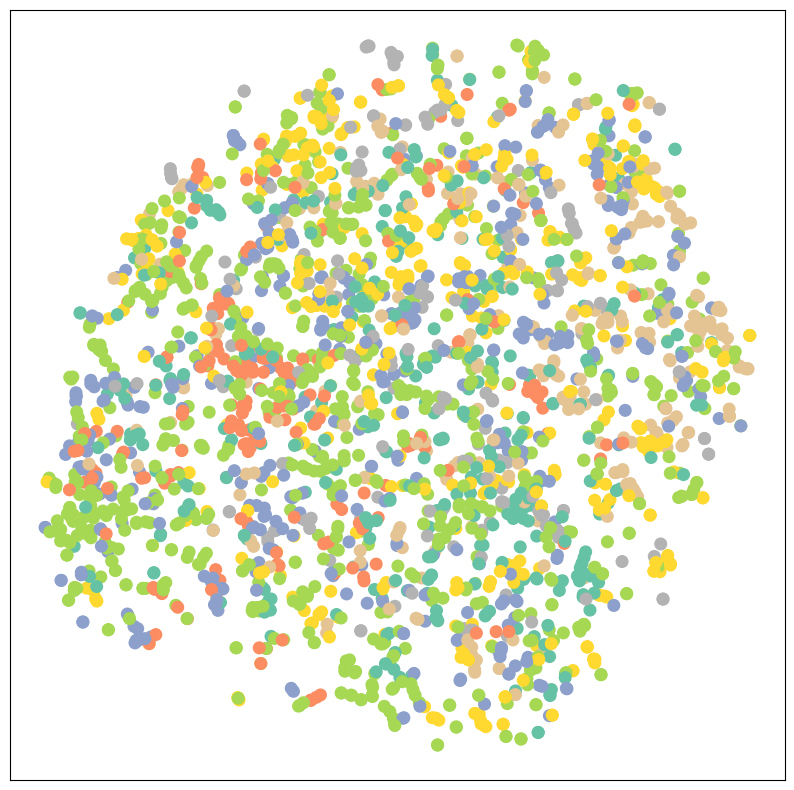

In [ ]:
%matplotlib inline

model = GCN(hidden_channels=16)
model.eval()

out = model(data.x, data.edge_index)
visualize(out, color=data.y)

In [ ]:
from IPython.display import Javascript  # Restrict height of output cell.
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 300})'''))

model = GCN(hidden_channels=16)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
criterion = torch.nn.CrossEntropyLoss()

def train():
      model.train()
      optimizer.zero_grad()  # Clear gradients.
      out = model(data.x, data.edge_index)  # Perform a single forward pass.
      loss = criterion(out[data.train_mask], data.y[data.train_mask])  # Compute the loss solely based on the training nodes.
      loss.backward()  # Derive gradients.
      optimizer.step()  # Update parameters based on gradients.
      return loss

def test():
      model.eval()
      out = model(data.x, data.edge_index)
      pred = out.argmax(dim=1)  # Use the class with highest probability.
      test_correct = pred[data.test_mask] == data.y[data.test_mask]  # Check against ground-truth labels.
      test_acc = int(test_correct.sum()) / int(data.test_mask.sum())  # Derive ratio of correct predictions.
      return test_acc


for epoch in range(1, 101):
    loss = train()
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}')

<IPython.core.display.Javascript object>

Epoch: 001, Loss: 1.9463
Epoch: 002, Loss: 1.9409
Epoch: 003, Loss: 1.9343
Epoch: 004, Loss: 1.9275
Epoch: 005, Loss: 1.9181
Epoch: 006, Loss: 1.9086
Epoch: 007, Loss: 1.9015
Epoch: 008, Loss: 1.8933
Epoch: 009, Loss: 1.8808
Epoch: 010, Loss: 1.8685
Epoch: 011, Loss: 1.8598
Epoch: 012, Loss: 1.8482
Epoch: 013, Loss: 1.8290
Epoch: 014, Loss: 1.8233
Epoch: 015, Loss: 1.8057
Epoch: 016, Loss: 1.7966
Epoch: 017, Loss: 1.7825
Epoch: 018, Loss: 1.7617
Epoch: 019, Loss: 1.7491
Epoch: 020, Loss: 1.7310
Epoch: 021, Loss: 1.7147
Epoch: 022, Loss: 1.7056
Epoch: 023, Loss: 1.6954
Epoch: 024, Loss: 1.6697
Epoch: 025, Loss: 1.6538
Epoch: 026, Loss: 1.6312
Epoch: 027, Loss: 1.6161
Epoch: 028, Loss: 1.5899
Epoch: 029, Loss: 1.5711
Epoch: 030, Loss: 1.5576
Epoch: 031, Loss: 1.5393
Epoch: 032, Loss: 1.5137
Epoch: 033, Loss: 1.4948
Epoch: 034, Loss: 1.4913
Epoch: 035, Loss: 1.4698
Epoch: 036, Loss: 1.3998
Epoch: 037, Loss: 1.4041
Epoch: 038, Loss: 1.3761
Epoch: 039, Loss: 1.3631
Epoch: 040, Loss: 1.3258


In [ ]:
test_acc = test()
print(f'Test Accuracy: {test_acc:.4f}')

Test Accuracy: 0.8150


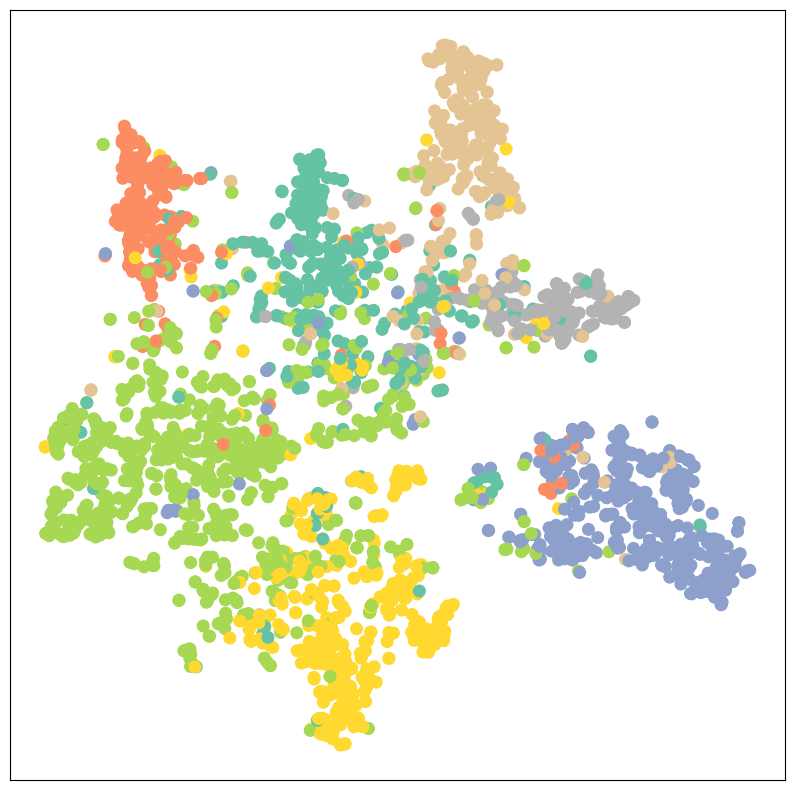

In [ ]:
model.eval()

out = model(data.x, data.edge_index)
visualize(out, color=data.y)

## Graph Attention Networks

- Graph Attention Networks (GATs) are an advanced type of GNN that use attention mechanisms to weigh the importance of neighboring nodes dynamically during feature aggregation [Veličković et al. (2018)](https://arxiv.org/abs/1710.10903)
- Unlike standard GCNs (which use fixed weights based on node degrees), GATs learn to focus on the most relevant neighbors for each node.

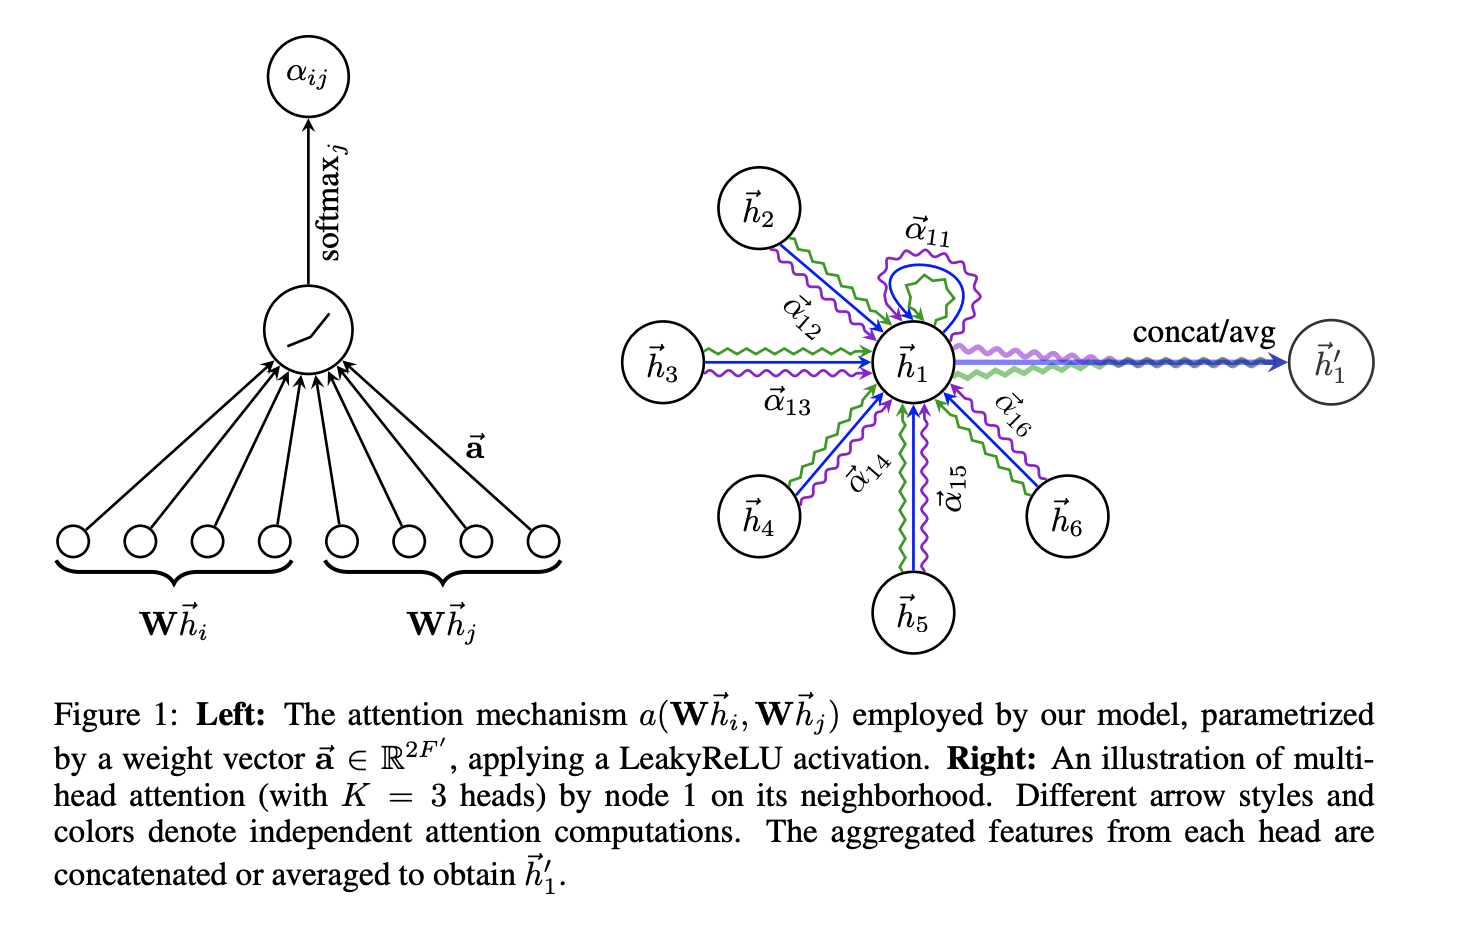

In [ ]:
from torch_geometric.nn import GATConv

class GAT(torch.nn.Module):
    def __init__(self, hidden_channels, heads):
        super().__init__()
        torch.manual_seed(1234567)
        self.conv1 = GATConv(dataset.num_features, hidden_channels, heads)
        self.conv2 = GATConv(hidden_channels*heads, dataset.num_classes)

    def forward(self, x, edge_index):
        x = F.dropout(x, p=0.6, training=self.training)
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=0.6, training=self.training)
        x = self.conv2(x, edge_index)
        return x

model = GAT(hidden_channels=64, heads=3)
print(model)

optimizer = torch.optim.Adam(model.parameters(), lr=0.005, weight_decay=5e-4)
criterion = torch.nn.CrossEntropyLoss()

def train():
      model.train()
      optimizer.zero_grad()  # Clear gradients.
      out = model(data.x, data.edge_index)  # Perform a single forward pass.
      loss = criterion(out[data.train_mask], data.y[data.train_mask])  # Compute the loss solely based on the training nodes.
      loss.backward()  # Derive gradients.
      optimizer.step()  # Update parameters based on gradients.
      return loss

def test(mask):
      model.eval()
      out = model(data.x, data.edge_index)
      pred = out.argmax(dim=1)  # Use the class with highest probability.
      correct = pred[mask] == data.y[mask]  # Check against ground-truth labels.
      acc = int(correct.sum()) / int(mask.sum())  # Derive ratio of correct predictions.
      return acc


for epoch in range(1, 101):
    loss = train()
    val_acc = test(data.val_mask)
    test_acc = test(data.test_mask)
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Val: {val_acc:.4f}, Test: {test_acc:.4f}')

GAT(
  (conv1): GATConv(1433, 64, heads=3)
  (conv2): GATConv(192, 7, heads=1)
)
Epoch: 001, Loss: 1.9444, Val: 0.4800, Test: 0.5070
Epoch: 002, Loss: 1.9366, Val: 0.6760, Test: 0.6670
Epoch: 003, Loss: 1.9252, Val: 0.7400, Test: 0.7120
Epoch: 004, Loss: 1.9154, Val: 0.7660, Test: 0.7350
Epoch: 005, Loss: 1.9008, Val: 0.7500, Test: 0.7510
Epoch: 006, Loss: 1.8849, Val: 0.7500, Test: 0.7550
Epoch: 007, Loss: 1.8656, Val: 0.7520, Test: 0.7530
Epoch: 008, Loss: 1.8521, Val: 0.7540, Test: 0.7580
Epoch: 009, Loss: 1.8356, Val: 0.7520, Test: 0.7600
Epoch: 010, Loss: 1.8154, Val: 0.7660, Test: 0.7750
Epoch: 011, Loss: 1.7934, Val: 0.7880, Test: 0.7850
Epoch: 012, Loss: 1.7577, Val: 0.7880, Test: 0.7860
Epoch: 013, Loss: 1.7465, Val: 0.7920, Test: 0.7910
Epoch: 014, Loss: 1.7198, Val: 0.7900, Test: 0.7910
Epoch: 015, Loss: 1.6978, Val: 0.7840, Test: 0.7910
Epoch: 016, Loss: 1.6680, Val: 0.7860, Test: 0.7940
Epoch: 017, Loss: 1.6445, Val: 0.7880, Test: 0.7980
Epoch: 018, Loss: 1.5969, Val: 0.79

In [ ]:
test_acc = test(data.test_mask)
print(f'Test Accuracy: {test_acc:.4f}')

Test Accuracy: 0.8190


## MUTAG dataset

- Benchmark dataset for ***graph classification*** in graph deep/machine learning.
- Binary classification of chemical compounds based on their mutagenic properties (whether they can cause genetic mutations).
- Key Features:
  - Graph Structure: 188 chemical compounds (graphs)
  - Binary Labels:
    - 1 (mutagenic): 63% of graphs
    - 0 (non-mutagenic): 37% of graphs
  - Node & Edge Attributes:
    - Nodes: Atoms (7 possible types, e.g., carbon, nitrogen)
    - Edges: Chemical bonds (4 bond types: single, double, triple, aromatic)


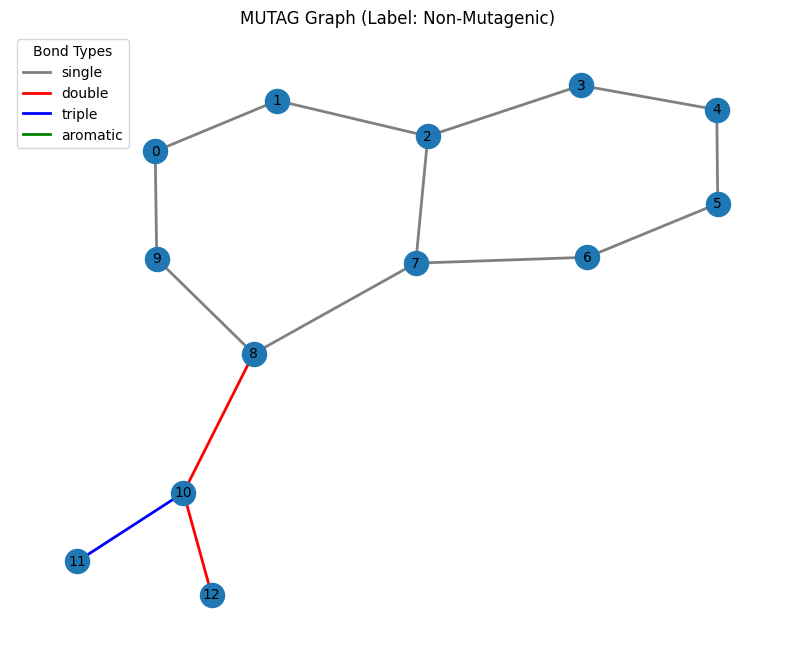

In [ ]:
from torch_geometric.datasets import TUDataset

dataset = TUDataset(root='data/TUDataset', name='MUTAG')

num_graph = 1
data = dataset[num_graph]

G = nx.Graph()

# Add edges with attributes (bond types)
for (src, dst), bond_type in zip(data.edge_index.t().tolist(),
                                data.edge_attr.argmax(dim=1).tolist()):
    G.add_edge(src, dst, bond_type=bond_type)

# Define visual properties
bond_types = {0: 'single', 1: 'double', 2: 'triple', 3: 'aromatic'}
edge_colors = {
    0: 'gray',  # single
    1: 'red',   # double
    2: 'blue',  # triple
    3: 'green'  # aromatic
}

# Node colors by atom type (if available)
node_colors = 'skyblue'
if hasattr(data, 'x'):
    node_colors = data.x.argmax(dim=1).tolist()

# Plot
plt.figure(figsize=(10, 8))
pos = nx.spring_layout(G, seed=42)

# Draw nodes
nx.draw_networkx_nodes(G, pos,
                      #node_color=node_colors,
                      cmap='Set1',
                      node_size=300)

# Draw edges with type-based coloring
edge_color_list = [edge_colors[G.edges[e]['bond_type']] for e in G.edges]
nx.draw_networkx_edges(G, pos,
                      edge_color=edge_color_list,
                      width=2)

# Add labels
nx.draw_networkx_labels(G, pos, font_size=10)

# Add edge type legend
edge_legend = [plt.Line2D([0], [0], color=color, lw=2, label=f'{bond_types[i]}')
               for i, color in edge_colors.items()]
plt.legend(handles=edge_legend, title='Bond Types')

plt.title(f'MUTAG Graph (Label: {"Mutagenic" if data.y.item() == 1 else "Non-Mutagenic"})')
plt.axis('off')
plt.show()

In [ ]:

dataset = TUDataset(root='data/TUDataset', name='MUTAG')

print()
print(f'Dataset: {dataset}:')
print('====================')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')

#  # Info for the first graph object.
data = dataset[0]
print()
print('=============================================================')
print(data)

# Gather some statistics about the first graph.
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
print(f'Is undirected: {data.is_undirected()}')


Dataset: MUTAG(188):
Number of graphs: 188
Number of features: 7
Number of classes: 2

Data(edge_index=[2, 38], x=[17, 7], edge_attr=[38, 4], y=[1])
Number of nodes: 17
Number of edges: 38
Average node degree: 2.24
Is undirected: True


In [ ]:
torch.manual_seed(12345)
dataset = dataset.shuffle()

train_dataset = dataset[:150]
test_dataset = dataset[150:]

print(f'Number of training graphs: {len(train_dataset)}')
print(f'Number of test graphs: {len(test_dataset)}')

Number of training graphs: 150
Number of test graphs: 38


In [ ]:
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [ ]:

class GCN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super(GCN, self).__init__()
        torch.manual_seed(12345)
        self.conv1 = GCNConv(dataset.num_node_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.conv3 = GCNConv(hidden_channels, hidden_channels)
        self.lin = Linear(hidden_channels, dataset.num_classes)

    def forward(self, x, edge_index, batch):
        # 1. Obtain node embeddings
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = self.conv2(x, edge_index)
        x = x.relu()
        x = self.conv3(x, edge_index)

        # 2. Readout layer
        x = global_mean_pool(x, batch)  # [batch_size, hidden_channels]

        # 3. Apply a final classifier
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin(x)

        return x

model = GCN(hidden_channels=64)
print(model)

GCN(
  (conv1): GCNConv(7, 64)
  (conv2): GCNConv(64, 64)
  (conv3): GCNConv(64, 64)
  (lin): Linear(in_features=64, out_features=2, bias=True)
)


In [ ]:
from IPython.display import Javascript
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 300})'''))

model = GCN(hidden_channels=64)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = torch.nn.CrossEntropyLoss()

def train():
    model.train()

    for data in train_loader:  # Iterate in batches over the training dataset.
         out = model(data.x, data.edge_index, data.batch)  # Perform a single forward pass.
         loss = criterion(out, data.y)  # Compute the loss.
         loss.backward()  # Derive gradients.
         optimizer.step()  # Update parameters based on gradients.
         optimizer.zero_grad()  # Clear gradients.

def test(loader):
     model.eval()

     correct = 0
     for data in loader:  # Iterate in batches over the training/test dataset.
         out = model(data.x, data.edge_index, data.batch)
         pred = out.argmax(dim=1)  # Use the class with highest probability.
         correct += int((pred == data.y).sum())  # Check against ground-truth labels.
     return correct / len(loader.dataset)  # Derive ratio of correct predictions.


for epoch in range(1, 100):
    train()
    train_acc = test(train_loader)
    test_acc = test(test_loader)
    print(f'Epoch: {epoch:03d}, Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}')

<IPython.core.display.Javascript object>

Epoch: 001, Train Acc: 0.6467, Test Acc: 0.7368
Epoch: 002, Train Acc: 0.6467, Test Acc: 0.7368
Epoch: 003, Train Acc: 0.6467, Test Acc: 0.7368
Epoch: 004, Train Acc: 0.6467, Test Acc: 0.7368
Epoch: 005, Train Acc: 0.6467, Test Acc: 0.7368
Epoch: 006, Train Acc: 0.6533, Test Acc: 0.7368
Epoch: 007, Train Acc: 0.7467, Test Acc: 0.7632
Epoch: 008, Train Acc: 0.7267, Test Acc: 0.7632
Epoch: 009, Train Acc: 0.7200, Test Acc: 0.7632
Epoch: 010, Train Acc: 0.7133, Test Acc: 0.7895
Epoch: 011, Train Acc: 0.7200, Test Acc: 0.7632
Epoch: 012, Train Acc: 0.7200, Test Acc: 0.7895
Epoch: 013, Train Acc: 0.7200, Test Acc: 0.7895
Epoch: 014, Train Acc: 0.7133, Test Acc: 0.8421
Epoch: 015, Train Acc: 0.7133, Test Acc: 0.8421
Epoch: 016, Train Acc: 0.7533, Test Acc: 0.7368
Epoch: 017, Train Acc: 0.7400, Test Acc: 0.7632
Epoch: 018, Train Acc: 0.7133, Test Acc: 0.8421
Epoch: 019, Train Acc: 0.7400, Test Acc: 0.7895
Epoch: 020, Train Acc: 0.7533, Test Acc: 0.7368
Epoch: 021, Train Acc: 0.7467, Test Acc:

# GNNs and Text Graphs

- The application areas of graph-based methods are extensive, spanning Social Studies, Chemistry, and NLP.
- Graphs effectively represent text documents by modeling relationships between words, sentences, or topics, enabling structured analysis.
- They are versatile tools for tasks like classification, topic modeling, and semantic analysis across diverse domains.
- However, generating these text representations from raw corpora can be complex, requiring careful consideration of linguistic structures, domain knowledge, and computational techniques.

# text2graphAPI


- Library to transform text documents into text graphs
- Currently supports three types of graph representations
  - Co-Ocurrence Graph
  - Heterogeneous Graph
  - Integrated Syntactic Graph
- Composed of three main modules
  - Pre-processing: text cleanning and normalization (spacy, nltk)
  - Graph Model: define/build nodes and edges according to the specifications
  - Graph Transformation: transform to text graph representation (networkx, adj matrix)

PYPI Repo: https://pypi.org/project/text2graphapi/

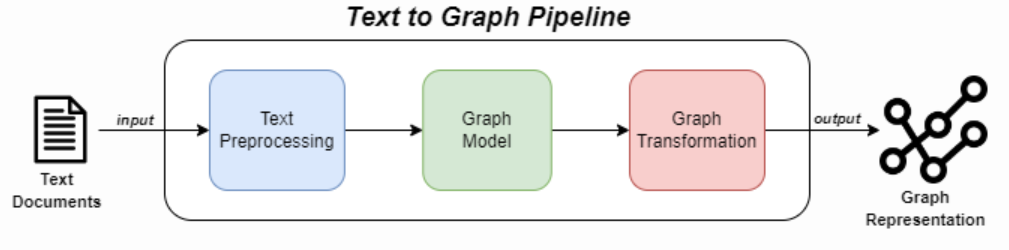

In [ ]:
#********************* TEXT INPUT STRUCTURE
'''
[
  {
    'id':   1,             (int)
    'doc': "text content"  (string)
    'context': {}          (dict)
  },
  {
    'id':   2,
    'doc': "text content"
    'context': {}
  },
  ...
]
'''

##********************* GRAPH OUPUT STRUCTURE
'''
[
  {
    'id': 1,                  (int)
    'graph': graph_output,    (networkx, adjacency_matrix, etc)
    'number_of_edges': 21,    (int)
    'number_of_nodes': 12,    (int)
    'status': 'success'       (success/fail)
  },
  ...
]
'''
print()

## CoOcurrence Graph

- Per 1 input document generates 1 graph as an output
- Entities and relations are built as:
  - Nodes: each word from the document
  - Edges : co-occurrence of two words from the document
- Weights are built as:
  - Nodes: Part of Speech tag (POS)
  - Edges: Co-ocurrence frequency

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
DEBUG:text2graphapi.src.Utils:Import libraries/modules from :PROD
INFO:text2graphapi.src.Preprocessing:Has already installed spacy model en_core_web_sm
INFO:text2graphapi.src.Cooccurrence:Init transformations: Text to Co-Ocurrence Graph
INFO:text2graphapi.src.Cooccurrence:Transforming 5 text documents...
INFO:text2graphapi.src.Cooccurrence:Done transformations



graph_output:  [{'doc_id': 1, 'graph': <networkx.classes.digraph.DiGraph object at 0x7b63c9376a50>, 'number_of_edges': 21, 'number_of_nodes': 12, 'status': 'success', 'context': {'target': 1}}, {'doc_id': 2, 'graph': <networkx.classes.digraph.DiGraph object at 0x7b63c9376dd0>, 'number_of_edges': 29, 'number_of_nodes': 16, 'status': 'success', 'context': {'target': 1}}, {'doc_id': 3, 'graph': <networkx.classes.digraph.DiGraph object at 0x7b63c945e950>, 'number_of_edges': 21, 'number_of_nodes': 11, 'status': 'success', 'context': {'target': 0}}, {'doc_id': 4, 'graph': <networkx.classes.digraph.DiGraph object at 0x7b63c94a7510>, 'number_of_edges': 15, 'number_of_nodes': 9, 'status': 'success', 'context': {'target': 1}}, {'doc_id': 5, 'graph': <networkx.classes.digraph.DiGraph object at 0x7b63c94373d0>, 'number_of_edges': 19, 'number_of_nodes': 10, 'status': 'success', 'context': {'target': 0}}]

doc 1  :  {'id': 2, 'doc': 'natural language processing refers branch computer science focus 

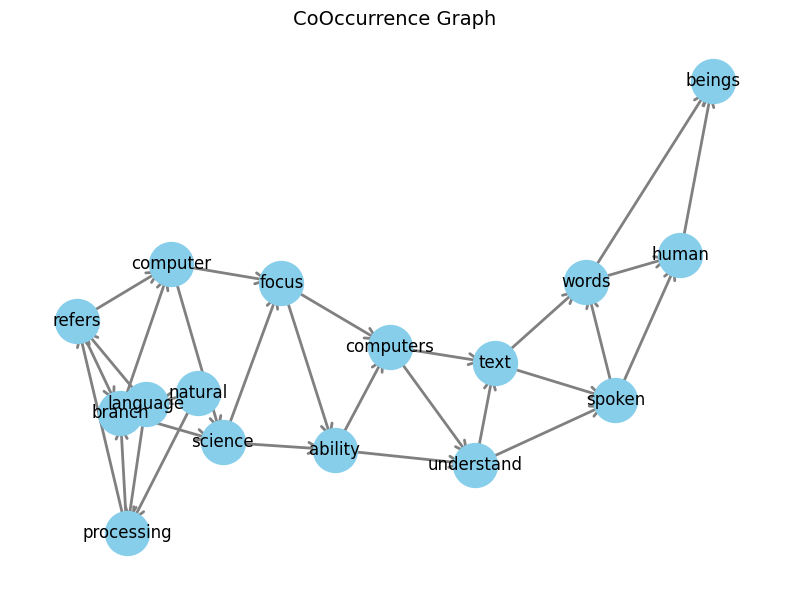

In [ ]:
# mencionar grafo y ejemplo con codigo usando la API

from text2graphapi.src.Cooccurrence  import Cooccurrence

def cooccur_graph_instance(lang='en'):
    # create co_occur object
    co_occur = Cooccurrence(
            graph_type = 'DiGraph',
            window_size = 2,
            apply_prep = True,
            steps_preprocessing = {
                "handle_blank_spaces": True,
                "handle_non_ascii": True,
                "handle_emoticons": True,
                "handle_html_tags": True,
                "handle_contractions": True,
                "handle_stop_words": True,
                "to_lowercase": True
            },
            parallel_exec = False,
            language = lang, #es, en, fr
            output_format = 'networkx'
        )
    return co_occur


# custom dataset
corpus_text_docs = read_custom_dataset()
t2graph = cooccur_graph_instance()

graph_output = t2graph.transform(corpus_text_docs)
for corpus_text_doc in corpus_text_docs:
    for g in graph_output:
        if g['doc_id'] == corpus_text_doc['id']:
            g['context'] = corpus_text_doc['context']
            break

doc_id = 1
print()
print("graph_output: ", graph_output)
print()
print(f"doc {doc_id}  : ", corpus_text_docs[doc_id])
print(f"graph {doc_id}: ", graph_output[doc_id])
print()
plot_digraph(graph_output[doc_id]['graph'], node_size=1000, layout='spring', edge_width_scale=2.0, title="CoOccurrence Graph")

## Heterogeneous Graph

- For multiple input documents (corpus) generates 1 graph as an output

- Entities and relations are built as:
  - Nodes: each Word and each Document (corpus)
  - Edges: Word-Word for co-occurrence and document-word when the word appears in the document

- Weights are built as:
  - Nodes: Part of Speech tag (POS) for Word nodes
  - Edges: PMI value for Word-Word relation and TF-IDF value for Document-Word relation

INFO:text2graphapi.src.Preprocessing:Has already installed spacy model en_core_web_sm
INFO:text2graphapi.src.Heterogeneous:Init transformations: Text to Heterogeneous Graph
INFO:text2graphapi.src.Heterogeneous:Transforming 5 text documents...
INFO:text2graphapi.src.Heterogeneous:Done transformations



text documents:  {'id': 1, 'doc': 'artificial intelligence ability digital computer computer controlled robot perform tasks commonly intelligent beings', 'context': {'target': 1}}
graph_output:    {'doc_id': 1, 'graph': <networkx.classes.digraph.DiGraph object at 0x7b63c8dd85d0>, 'number_of_edges': 113, 'number_of_nodes': 56, 'status': 'success', 'context': {'target': 1}}



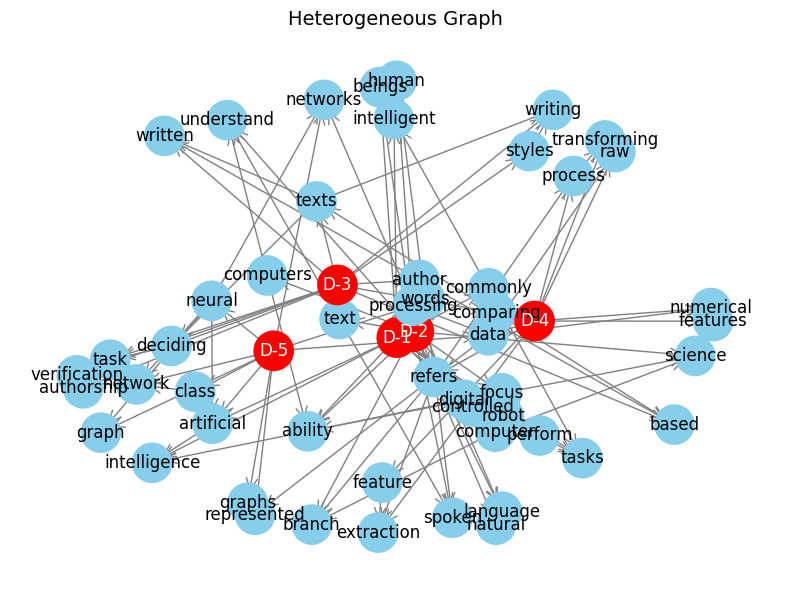

In [ ]:
# mencionar grafo y ejemplo con codigo usando la API

from text2graphapi.src.Heterogeneous  import Heterogeneous

import matplotlib.pyplot as plt
import networkx as nx

import matplotlib.pyplot as plt
import networkx as nx

def plot_digraph_with_highlight(G, highlight_prefix="D-",
                              default_color="skyblue", highlight_color="red",
                              default_text="black", highlight_text="white"):
    """
    Visualize a NetworkX DiGraph with specific nodes highlighted and custom text colors.

    Args:
        G (nx.DiGraph): Your directed graph
        highlight_prefix (str): Prefix of nodes to highlight (e.g., "D-")
        default_color (str): Color for non-highlighted nodes
        highlight_color (str): Color for highlighted nodes
        default_text (str): Text color for non-highlighted nodes
        highlight_text (str): Text color for highlighted nodes
    """
    # Generate layout
    pos = nx.spring_layout(G, seed=42)

    # Create color and text color lists
    node_colors = []
    text_colors = []
    for node in G.nodes():
        if str(node).startswith(highlight_prefix):
            node_colors.append(highlight_color)
            text_colors.append(highlight_text)
        else:
            node_colors.append(default_color)
            text_colors.append(default_text)

    # Plot
    plt.figure(figsize=(8, 6))

    # Draw nodes
    nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=800)

    # Draw edges
    nx.draw_networkx_edges(G, pos, edge_color="gray", arrows=True, arrowstyle="->", arrowsize=20)

    # Draw labels with custom text colors
    labels = nx.get_node_attributes(G, 'label') if hasattr(G, 'label') else {n: n for n in G.nodes()}
    for node, (x, y) in pos.items():
        plt.text(x, y, labels[node],
                fontsize=12,
                ha='center',
                va='center',
                color=text_colors[list(G.nodes()).index(node)])

    plt.title("Heterogeneous Graph", fontsize=14)
    plt.axis("off")
    plt.tight_layout()
    plt.show()


def hetero_graph_instance(lang='en'):
    # create co_occur object
    hetero_graph = Heterogeneous(
        graph_type = 'DiGraph',
        window_size = 2,
        apply_prep = True,
        steps_preprocessing = {
            "handle_blank_spaces": True,
            "handle_non_ascii": True,
            "handle_emoticons": True,
            "handle_html_tags": True,
            "handle_contractions": True,
            "handle_stop_words": True,
            "to_lowercase": True
        },
        parallel_exec = False,
        load_preprocessing = False,
        language = lang, #sp, en, fr
        output_format = 'networkx',
    )
    return hetero_graph


# custom dataset
corpus_text_docs = read_custom_dataset()
t2graph = hetero_graph_instance()

graph_output = t2graph.transform(corpus_text_docs)
for corpus_text_doc in corpus_text_docs:
    for g in graph_output:
        if g['doc_id'] == corpus_text_doc['id']:
            g['context'] = corpus_text_doc['context']
            break

#print(graph_output)
#plot_digraph(graph_output[0]['graph'], node_size=1000, layout='spring', edge_width_scale=2.0)

print()
print("text documents: ", corpus_text_docs[0])
print("graph_output:   ", graph_output[0])
print()
#plot_digraph(graph_output[0]['graph'], node_size=1000, layout='spring', edge_width_scale=2.0, title="Heterogeneous Graph")
plot_digraph_with_highlight(graph_output[0]['graph'], highlight_prefix="D-")


# GenAI Text Detection using Text Graphs

- Given a text document identify if the text was written for a HUMAN or MACHINE

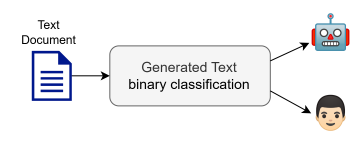

- Graph Deep Learning Pipeline

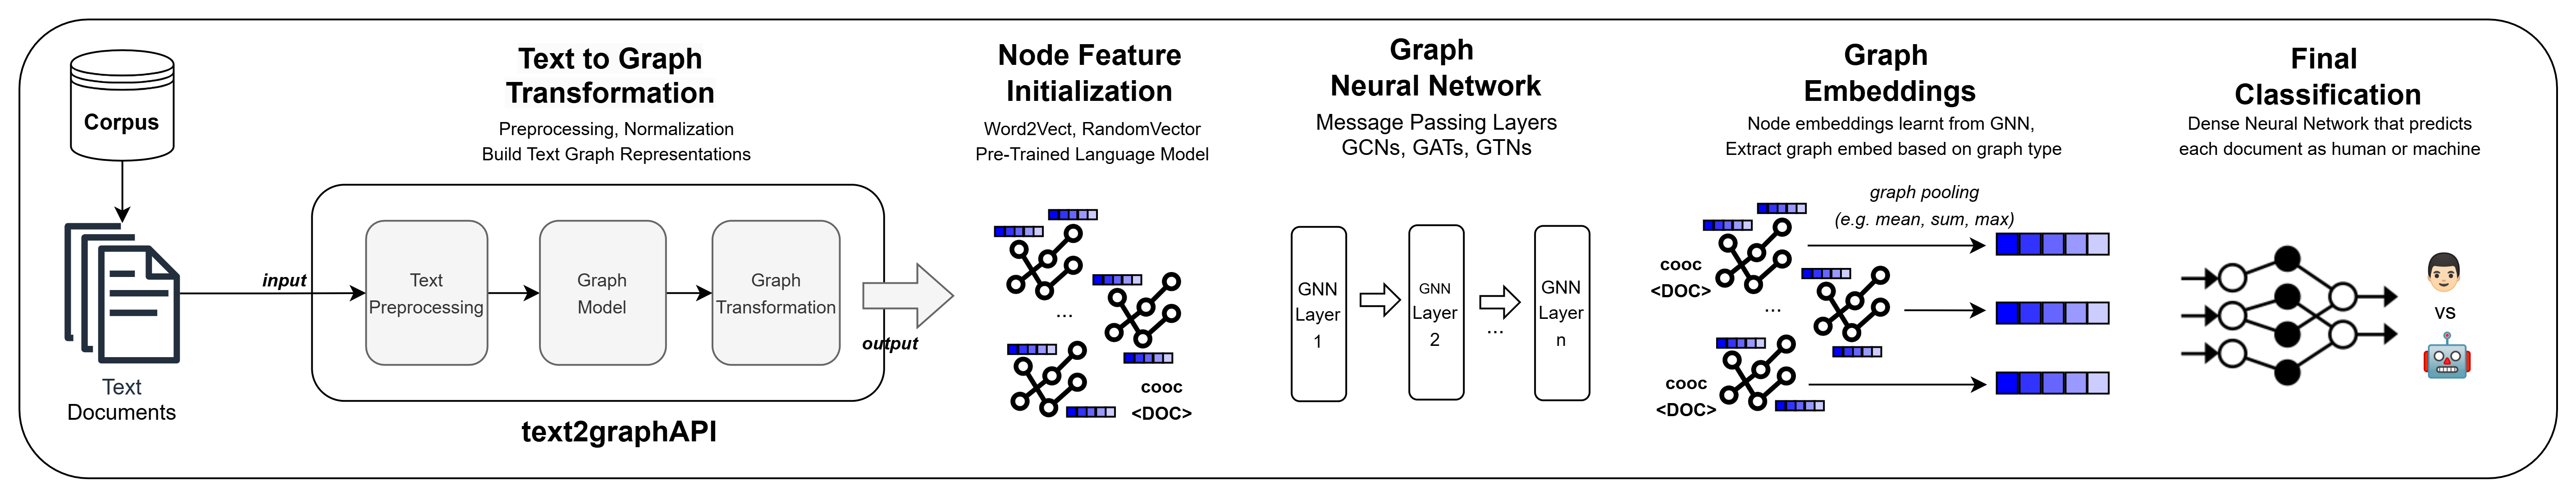

In [ ]:
autext23_train_df, autext23_val_df, autext23_test_df = read_autext23_dataset()
print(autext23_train_df.info())

print()
print("shape_train_set: ", autext23_train_df.shape)
print("shape_val_set: ", autext23_val_df.shape)
print("shape_test_set: ", autext23_test_df.shape)
print()
print("label_distro_train_set: ", autext23_train_df['label'].value_counts())
print("label_distro_val_set: ", autext23_val_df['label'].value_counts())
print("label_distro_test_set: ", autext23_test_df['label'].value_counts())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23691 entries, 0 to 23690
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  23691 non-null  int64 
 1   id          23691 non-null  int64 
 2   prompt      23691 non-null  object
 3   text        23691 non-null  object
 4   label       23691 non-null  int64 
 5   domain      23691 non-null  object
 6   model       23691 non-null  object
dtypes: int64(3), object(4)
memory usage: 1.3+ MB
None

shape_train_set:  (23691, 7)
shape_val_set:  (10154, 7)
shape_test_set:  (21832, 7)
label_distro_train_set:  label
0    11963
1    11728
Name: count, dtype: int64
label_distro_val_set:  label
0    5083
1    5071
Name: count, dtype: int64
label_distro_test_set:  label
1    11190
0    10642
Name: count, dtype: int64


In [ ]:
# Cut off datasets
cut_off_dataset = 10
autext23_train_df = autext23_train_df[:int(len(autext23_train_df) * (cut_off_dataset / 100))][:]
autext23_val_df = autext23_val_df[:int(len(autext23_val_df) * (cut_off_dataset / 100))][:]
autext23_test_df = autext23_test_df[:int(len(autext23_test_df) * (cut_off_dataset / 100))][:]
#autext23_train_df['label'].value_counts()

In [ ]:
autext23_train = process_autext23_dataset(autext23_train_df)
autext23_val = process_autext23_dataset(autext23_val_df)
autext23_test = process_autext23_dataset(autext23_test_df)

In [ ]:
t2graph = cooccur_graph_instance()
graphs_train = t2graph.transform(autext23_train)
graphs_val = t2graph.transform(autext23_val)
graphs_test = t2graph.transform(autext23_test)


INFO:text2graphapi.src.Preprocessing:Has already installed spacy model en_core_web_sm
INFO:text2graphapi.src.Cooccurrence:Init transformations: Text to Co-Ocurrence Graph
INFO:text2graphapi.src.Cooccurrence:Transforming 2369 text documents...
INFO:text2graphapi.src.Cooccurrence:Done transformations
INFO:text2graphapi.src.Cooccurrence:Init transformations: Text to Co-Ocurrence Graph
INFO:text2graphapi.src.Cooccurrence:Transforming 1015 text documents...
INFO:text2graphapi.src.Cooccurrence:Done transformations
INFO:text2graphapi.src.Cooccurrence:Init transformations: Text to Co-Ocurrence Graph
INFO:text2graphapi.src.Cooccurrence:Transforming 2183 text documents...
INFO:text2graphapi.src.Cooccurrence:Done transformations


In [ ]:
graphs_train = add_context(autext23_train, graphs_train)
graphs_val = add_context(autext23_val, graphs_val)
graphs_test = add_context(autext23_test, graphs_test)

docu_id = 1
graphs_train[docu_id]

{'doc_id': 26272,
 'graph': <networkx.classes.digraph.DiGraph at 0x7b63c82c2050>,
 'number_of_edges': 67,
 'number_of_nodes': 33,
 'status': 'success',
 'context': {'label': 0,
  'text': 'Take several deep breathes to collect yourself before moving on, which allows you to address your thoughts clearly and with a level head. By focusing your mind on your breathing for a moment, you give yourself some distance from your thoughts and make them easier to manage. Studies show that it takes 90 seconds for neurochemical triggers to fade from your brain and return you to a normal brain chemistry, so try counting to 90 to calm yourself down. Constantly ruminating on the past, which you have no',
  'model': 'NO-MODEL'}}

In [ ]:
from torch_geometric.utils.convert import from_networkx
from transformers import AutoTokenizer, AutoModel

def get_node_features_from_doc(graph, text, tokenizer, model, device, max_length=512):
    # 1. Tokenize entire document
    inputs = tokenizer(text, return_tensors="pt", truncation=True, max_length=max_length)
    inputs = {k: v.to(device) for k, v in inputs.items()}
    graph_nodes = list(graph.nodes())

    model.eval()
    with torch.no_grad():
        outputs = model(**inputs)
        hidden_states = outputs.last_hidden_state.squeeze(0)  # [seq_len, hidden_dim]

    input_tokens = tokenizer.convert_ids_to_tokens(inputs['input_ids'].squeeze(0))
    token_map = {
        token.lstrip("Ġ▁").lower(): i
        for i, token in enumerate(input_tokens)
    }
    node_features = []

    match_cnt = 0
    no_match_cnt = 0
    cls_embedding = hidden_states[0].detach().cpu()
    for node in graph_nodes:
        word = node.lower()

        idx = token_map.get(word)
        if idx is not None:
            match_cnt += 1
            node_features.append(hidden_states[idx].detach().cpu())
        else:
            no_match_cnt += 1
            node_features.append(torch.zeros(model.config.hidden_size).detach().cpu())

    #print(graph.number_of_nodes(), graph.number_of_edges(), match_cnt, no_match_cnt)
    return torch.stack(node_features)  # shape: [num_nodes, hidden_dim]


def extract_feat(graph_data, device, tokenizer, lang_model, set="train"):
    data_list = []
    for g_instance in tqdm(graph_data, desc=f"graph-feat {set}: "):
      try:
        doc_id = g_instance['doc_id']
        graph = g_instance['graph']
        text = g_instance['context']['text']
        label = g_instance['context']['label']

        # Extract node features
        node_feats = get_node_features_from_doc(graph, text, tokenizer, lang_model, device)
        features = [node_feats]
        node_feats = torch.cat(features, dim=1)

        # Convert to PyG
        pyg_data = from_networkx(graph)
        del pyg_data.pos_tag
        del pyg_data.freq
        pyg_data.x = node_feats
        pyg_data.y = torch.tensor([label])
        data_list.append(pyg_data)
      except Exception as e:
        ...

    return data_list


#device = 'cpu'
device = torch.device(f"cuda:0" if torch.cuda.is_available() else "cpu")
lang_model_name = 'google-bert/bert-base-uncased'
tokenizer = AutoTokenizer.from_pretrained(lang_model_name)
lang_model = AutoModel.from_pretrained(lang_model_name).to(device)

data_train_list = extract_feat(graphs_train, device, tokenizer, lang_model, set="train")
data_val_list = extract_feat(graphs_val, device, tokenizer, lang_model, set="val")
data_test_list = extract_feat(graphs_test, device, tokenizer, lang_model, set="test")


graph-feat test: 100%|██████████| 2183/2183 [00:28<00:00, 75.90it/s]


In [ ]:
data_train_list[1]

Data(edge_index=[2, 67], num_nodes=33, x=[33, 768], y=[1])

In [ ]:
train_loader = DataLoader(data_train_list, batch_size=256, shuffle=True)
val_loader = DataLoader(data_val_list, batch_size=256, shuffle=True)
test_loader = DataLoader(data_test_list, batch_size=256, shuffle=False)

In [ ]:
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
import torch.nn.functional as F
import torch.nn as nn
from torch_geometric.nn import (
    GCNConv, GATConv, TransformerConv,
    global_mean_pool, global_max_pool, global_add_pool,
    GlobalAttention, Set2Set
)

class GNN(nn.Module):
    def __init__(
        self,
        input_dim,
        hidden_dim,
        dense_hidden_dim,
        output_dim,
        dropout,
        num_layers,
        edge_attr=False,
        gnn_type='GCNConv',
        heads=1,
        task='node',
        norm_type='batchnorm',   # 'batchnorm', 'layernorm', or None
        post_mp_layers=3,        # number of layers after message passing
        pooling_type='mean'      # 'mean', 'max', 'sum', 'attention', 'set2set'
    ):
        super(GNN, self).__init__()
        self.task = task
        self.heads = heads
        self.gnn_type = gnn_type
        self.edge_attr = edge_attr
        self.dropout = dropout
        self.num_layers = num_layers
        self.norm_type = norm_type

        # First conv
        self.conv1 = self.build_conv_model(input_dim, hidden_dim, heads)
        self.norm1 = self.build_norm_layer(hidden_dim * heads)

        # Additional conv layers
        self.convs = nn.ModuleList()
        self.norms = nn.ModuleList()
        for _ in range(num_layers):
            self.convs.append(self.build_conv_model(hidden_dim * heads, hidden_dim, heads))
            self.norms.append(self.build_norm_layer(hidden_dim * heads))

        # Global Pooling
        self.global_pool = self.get_pooling_layer(pooling_type, hidden_dim * heads)

        # Post-message-passing MLP
        dims = [hidden_dim * heads] + [dense_hidden_dim // (2 ** i) for i in range(post_mp_layers - 1)] + [output_dim]
        post_mp = []
        for i in range(len(dims) - 1):
            post_mp.append(nn.Linear(dims[i], dims[i + 1]))
            #if i < len(dims) - 2:
            #    post_mp.append(nn.ReLU())
        self.post_mp = nn.Sequential(*post_mp)

    def build_conv_model(self, input_dim, hidden_dim, heads):
        if self.gnn_type == 'GCNConv':
            return GCNConv(input_dim, hidden_dim)
        elif self.gnn_type == 'GINConv':
            return GCNConv(input_dim, hidden_dim)
        elif self.gnn_type == 'GATConv':
            return GATConv(input_dim, hidden_dim, heads=heads)
        elif self.gnn_type == 'TransformerConv':
            if self.edge_attr:
                return TransformerConv(input_dim, hidden_dim, heads=heads, edge_dim=32)
            else:
                return TransformerConv(input_dim, hidden_dim, heads=heads)
        else:
            raise ValueError(f"Unsupported GNN type: {self.gnn_type}")

    def build_norm_layer(self, dim):
        if self.norm_type == 'batchnorm':
            return nn.BatchNorm1d(dim)
        elif self.norm_type == 'layernrom':
            return nn.LayerNorm(dim)
        else:
            return nn.Identity()

    def get_pooling_layer(self, pooling_type, hidden_dim):
        if pooling_type == 'mean':
            return global_mean_pool
        elif pooling_type == 'max':
            return global_max_pool
        elif pooling_type == 'sum':
            return global_add_pool
        elif pooling_type == 'attention':
            gate_nn = nn.Sequential(nn.Linear(hidden_dim, 1))
            return GlobalAttention(gate_nn)
        elif pooling_type == 'set2set':
            return Set2Set(hidden_dim, processing_steps=3)
        else:
            raise ValueError(f"Unsupported pooling type: {pooling_type}")


    def get_graph_embedding(self, x, edge_index, edge_attr=None, batch=None):
        if self.edge_attr:
            x = self.conv1(x, edge_index, edge_attr)
        else:
            x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.norm1(x)
        x = F.dropout(x, p=self.dropout, training=self.training)

        for i in range(self.num_layers):
            if self.edge_attr:
                x = self.convs[i](x, edge_index, edge_attr)
            else:
                x = self.convs[i](x, edge_index)
            x = F.relu(x)
            x = self.norms[i](x)
            x = F.dropout(x, p=self.dropout, training=self.training)

        x = self.global_pool(x, batch)
        return x

    def forward(self, x, edge_index, edge_attr=None, batch=None):
        x = self.get_graph_embedding(x, edge_index, edge_attr, batch)
        logits = self.post_mp(x)
        return logits


def test_gnn(model, device, loader, criterion):
    model.eval()
    all_loss = 0.0
    correct = 0
    all_preds = []
    all_labels = []
    for data in loader:
        data = data.to(device)
        with torch.no_grad():
            #out = model(data)
            out = model(data.x, data.edge_index, None, data.batch)
        pred = out.argmax(dim=1)
        all_preds.extend(pred.cpu().numpy())
        all_labels.extend(data.y.cpu().numpy())
        correct += int((pred == data.y).sum())
        loss = criterion(out, data.y)
        all_loss += loss.item()

    f1_macro = f1_score(all_labels, all_preds, average='macro')
    accuracy = correct / len(loader.dataset)
    return f1_macro, accuracy, all_loss / len(loader), all_preds, all_labels


In [ ]:
model = GNN(
      input_dim = 768,
      hidden_dim = 100, # 128, 100, 64
      dense_hidden_dim = 32, # 64 32
      output_dim = 2,
      dropout = 0.5,
      num_layers = 2, # message passing layers (1,2,3)
      gnn_type = 'GATConv', # GCNConv, GATConv, TransformerConv
      heads = 1,
      norm_type = 'batchnorm', # batchnorm, layernorm
      pooling_type = 'mean', # mean, max
      post_mp_layers = 2
  ).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.00005, weight_decay=1e-4)
criterion = torch.nn.CrossEntropyLoss()
print(model)

GNN(
  (conv1): GATConv(768, 100, heads=1)
  (norm1): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (convs): ModuleList(
    (0-1): 2 x GATConv(100, 100, heads=1)
  )
  (norms): ModuleList(
    (0-1): 2 x BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (post_mp): Sequential(
    (0): Linear(in_features=100, out_features=32, bias=True)
    (1): Linear(in_features=32, out_features=2, bias=True)
  )
)


In [ ]:
best_test_acc_score = 0
best_test_f1_score = 0
stop_epoch = 0
for epoch in range(100):
    model.train()
    train_loss = 0.0
    for data in train_loader:
        data = data.to(device)
        optimizer.zero_grad()
        out = model(data.x, data.edge_index, data.edge_attr, data.batch)
        loss = criterion(out, data.y)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    train_loss = train_loss / len(train_loader)
    val_f1_macro, val_accuracy, val_loss, _, _ = test_gnn(model, device, val_loader, criterion)
    test_f1_macro, test_accuracy, test_loss, _, _ = test_gnn(model, device, test_loader, criterion)

    print(f"Epoch {epoch:02d} | Train-Loss {train_loss:4f}  | Val-Loss {val_loss:4f} | Val-Acc: {val_accuracy:4f} | Test-Loss {test_loss:4f} | Test-Acc: {test_accuracy:4f}")


Epoch 00 | Train-Loss 0.705533  | Val-Loss 0.698081 | Val-Acc: 0.518738 | Test-Loss 0.704093 | Test-Acc: 0.493126
Epoch 01 | Train-Loss 0.701323  | Val-Loss 0.696784 | Val-Acc: 0.525641 | Test-Loss 0.707912 | Test-Acc: 0.489918
Epoch 02 | Train-Loss 0.689311  | Val-Loss 0.691065 | Val-Acc: 0.522682 | Test-Loss 0.709551 | Test-Acc: 0.489459
Epoch 03 | Train-Loss 0.687120  | Val-Loss 0.684195 | Val-Acc: 0.531558 | Test-Loss 0.709722 | Test-Acc: 0.492667
Epoch 04 | Train-Loss 0.678432  | Val-Loss 0.678191 | Val-Acc: 0.544379 | Test-Loss 0.708996 | Test-Acc: 0.497250
Epoch 05 | Train-Loss 0.673072  | Val-Loss 0.673201 | Val-Acc: 0.556213 | Test-Loss 0.707727 | Test-Acc: 0.499542
Epoch 06 | Train-Loss 0.665928  | Val-Loss 0.668435 | Val-Acc: 0.566075 | Test-Loss 0.706223 | Test-Acc: 0.501375
Epoch 07 | Train-Loss 0.658578  | Val-Loss 0.664185 | Val-Acc: 0.582840 | Test-Loss 0.704261 | Test-Acc: 0.505958
Epoch 08 | Train-Loss 0.653210  | Val-Loss 0.660108 | Val-Acc: 0.591716 | Test-Loss 0.70

In [ ]:
from collections import Counter, defaultdict

test_f1_macro, test_accuracy, test_loss, preds_test, labels_test = test_gnn(model, device, test_loader, criterion)
print(f" ----> Test-Loss {test_loss:4f} | Test-Acc: {test_accuracy:4f} | Test-F1Macro: {test_f1_macro:4f}")

print("preds_test:  ", sorted(Counter(preds_test).items()))
print("labels_test: ", sorted(Counter(labels_test).items()))

 ----> Test-Loss 0.677526 | Test-Acc: 0.697525 | Test-F1Macro: 0.697452
preds_test:   [(np.int64(0), 1132), (np.int64(1), 1050)]
labels_test:  [(np.int64(0), 1084), (np.int64(1), 1098)]


# Conclusions

- Performance comparison on test set (F1-macro) for different approaches and our GTN Text Graphs method.
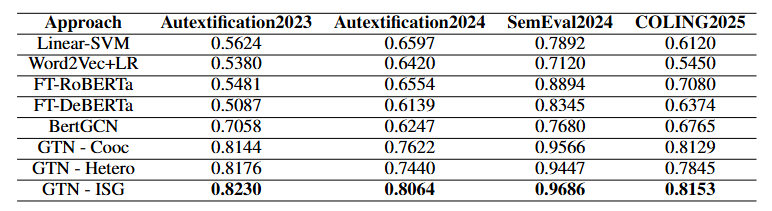

- Comparison performance between the best work-
shop systems and our graph’s approach.
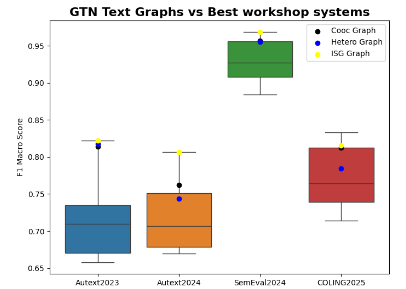

- PAN CLEF - Generative AI Detection 2025
- Final leaderboard ranking for subtask 1.
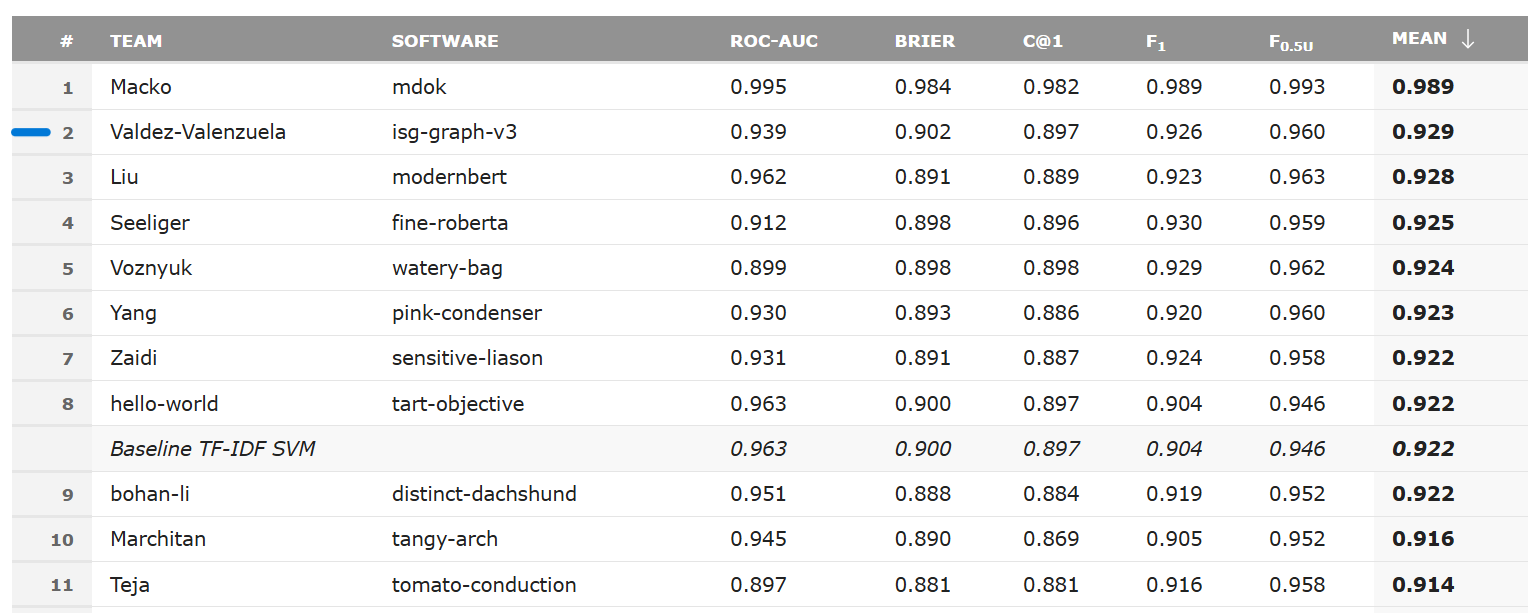

# Resources

- text2graphAPI: https://pypi.org/project/text2graphapi/
- pytorch geometric: https://pytorch-geometric.readthedocs.io/en/2.5.2/index.html
- Stanford CS224W - Machine Learning with Graphs: https://www.youtube.com/playlist?list=PLoROMvodv4rPLKxIpqhjhPgdQy7imNkDn
- A Comprehensive Introduction to GNNs: https://www.datacamp.com/tutorial/comprehensive-introduction-graph-neural-networks-gnns-tutorial
- Web App text2graphAPI: http://132.248.51.189:8000/graph-form/
- Graph Convolutional Networks for Text Classification [Liang Yao et al. (2018)](https://arxiv.org/abs/1809.05679)
- Graph Neural Networks for Text Classification: A Survey
 [Kunze Wang et al. (2023)](https://arxiv.org/abs/2304.11534)
- Graph Neural Networks: A Review of Methods and Applications
 [Jie Zhou et al. (2018)](https://arxiv.org/abs/1812.08434)